In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
#for xgboost model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
#for checking xgboost model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

## Monte Carlo Simulation

This is the start of the file where I will put together my volatility modeling from before and compare its performance with volatilities used by traditional pricing models. The models I will be looking at are:
- black sholes with a constant volatility
- heston with a stochastically calculated volatility
- monte carlo simulation with black sholes to utilize my own modeled volatility
- maybe hull-white with stochastically calculated volatility

We will first get the stock data we will need.

In [ ]:
#Stock data preparation
# gather data
stockgrp = pd.read_excel("10yrClosingPricesStocks.xlsx")
stockgrp = stockgrp.drop(columns=['Date'])

#calculate log returns then volatility
returns = np.log(stockgrp / stockgrp.shift(1))
volatility = returns.rolling(window=20).std() * np.sqrt(252)
volatility = volatility.dropna()

#we will work with the average of our 18 stocks to fit a marketwide view
avg_volatility = volatility.mean(axis=1) 
avg_volatility = avg_volatility.to_frame()
avg_volatility.columns = ['volatility']

#if we want to see the full dataset
def plot_avg(data):
    plt.figure(figsize=(10,5))
    plt.plot(data, label="Average Volatility", color="blue")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.title("Market-Wide Average Volatility")
    plt.legend()
    plt.show()
#plot_avg(avg_volatility.tail(500))

In [21]:
#What we will actually need is the stock price on the first day of the test set - day 2001(roughly) or 1st day of test set
# we will also need the test data
# finally we will need the data we predicted based off the xgboost model, which we will import in
#so to do this we will need to repeat our creation of the xgboost model along with the preprocessing we did to the data before we ran the model
#Starting off with the lagged features function which shifts the data by a certain number of days
def create_lagged_features(data, lag=30):
    df = pd.DataFrame(data, columns=['volatility'])
    for i in range(1, lag+1):
        df[f'lag_{i}'] = df['volatility'].shift(i)
    df.dropna(inplace=True)
    return df

lag = 30 #number of lagged days
data = create_lagged_features(avg_volatility, lag=lag)
#split into features and target
X = data.drop(columns=['volatility']).values
y = data['volatility'].values

#split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

#scale features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#now the model training
#Now our data is ready and we can actually build our XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=100, #number of trees
    learning_rate=0.1, #step size shrinkage
    max_depth=5, #max depth of a tree
    subsample=0.8, #fraction of samples used for training each tree
    colsample_bytree=0.8, #Fraction of features used for training each tree
    random_state=42
)
#train the model
xgb_model.fit(X_train, y_train)
#make predictions
xgb_predictions = xgb_model.predict(X_test)

def xgb_visualize():
    #start with metrics
    rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
    mae = mean_absolute_error(y_test, xgb_predictions)
    r2 = r2_score(y_test, xgb_predictions)
    print(f"XGBoost RMSE: {rmse}")
    print(f"XGBoost MAE: {mae}")
    print(f"XGBoost R²: {r2}")

    #now plot actual v predicted
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual', color='blue')
    plt.plot(xgb_predictions, label='Predicted', color='orange')
    plt.title('Actual vs Predicted Volatility (XGBoost)')
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()
#if we want to see the xgbmodel we can uncomment the below function call - to check if the model is working properly
#xgb_visualize()

#so our data we will use from here is:
# 1st element of stockgrp on day 1998(1st day of test set) will be the stock price
# the average of y_train will be sigma or our constant volatility
# for the enhanced bs model we will need the predicted data to plug into the volatility

In [24]:
#Black Scholes with constant volatility from training set - past data
#simulated with a monte carlo simulation

#start with initial parameters
stock_price = np.mean(stockgrp.iloc[1998])  #day 1 price of our stock's averaged
sigma = np.mean(y_train) #averaged out volatility from the training data - black-scholes doesnt know our test data
mu = .03    #risk free rate - standard rate
K = stock_price #strike price - we will go with at the money so same as initial price
#time params
T = 2   #time horizon in years
num_simulations = 10000 #number of simulations or runs of the monte carlo    
num_steps = 500   #number of steps, but also just number of days in the datasets
dt = T/num_steps    #dt plugs into formula
time = np.linspace(0, T, num_steps) #optional for plotting

#now for the simulations
#simulate paths
price_paths = np.zeros((num_simulations, num_steps))
price_paths[:,0] = 50

#simulate paths using GBM formula
for t in range(1, num_steps):
    z = np.random.standard_normal(num_simulations)  #add in random shocks based on normal distribution
    #now our actual Geometric Brownian Motion equation derived from black-scholes
    #we also disctretize the equation to make it applicable to a monte carlo simulation
    price_paths[:, t] = price_paths[:, t-1] * np.exp((mu - (sigma**2)*0.5) * dt + sigma * np.sqrt(dt) * z)

#final results
final_prices = price_paths[:, -1]   #final path to be simulated
log_returns = np.log(final_prices / stock_price)    #returns calculated from those prices

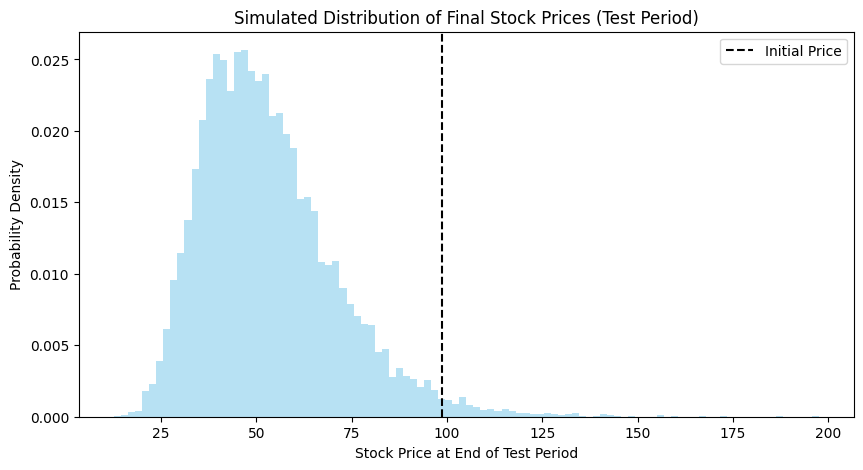

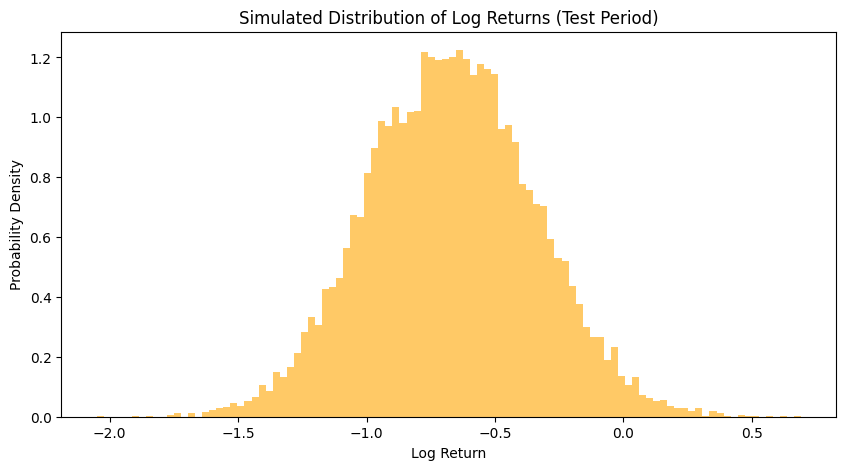

In [28]:
#visualize price distribution
plt.figure(figsize=(10, 5))
plt.hist(final_prices, bins=100, density=True, alpha=0.6, color='skyblue')
plt.axvline(stock_price, color='black', linestyle='--', label='Initial Price')
plt.title("Simulated Distribution of Final Stock Prices (Test Period)")
plt.xlabel("Stock Price at End of Test Period")
plt.ylabel("Probability Density")
plt.legend()
plt.show()

#visualize returns distribution
plt.figure(figsize=(10, 5))
plt.hist(log_returns, bins=100, density=True, alpha=0.6, color='orange')
plt.title("Simulated Distribution of Log Returns (Test Period)")
plt.xlabel("Log Return")
plt.ylabel("Probability Density")
plt.show()

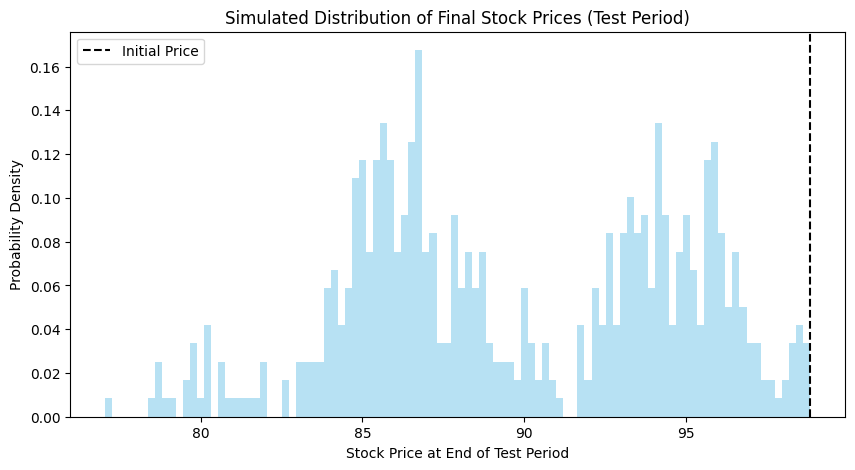

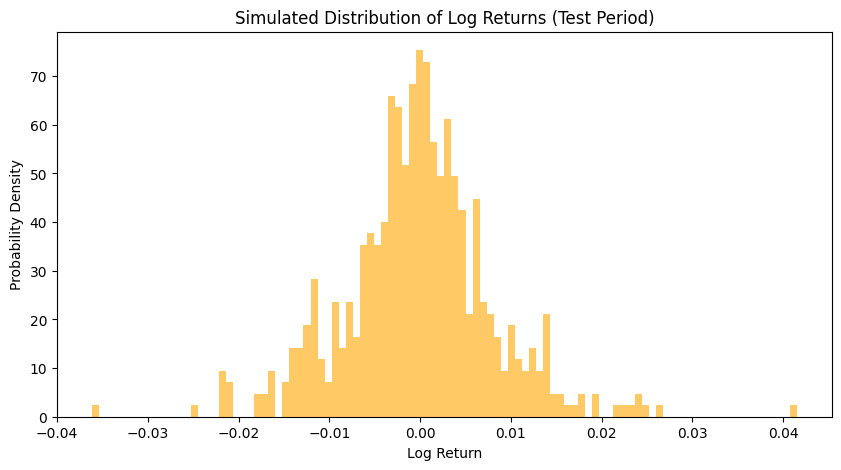

In [37]:
#now I want to print the actual returns and price distribution of the averaged stocks during that period
#just to compare to what happened in real life

#create a new dataframe with one row that has the average of all 18 stocks closing prices
stockgrp_avg = stockgrp.iloc[1998:-1].mean(axis=1)
#calc log_returns for that group
stockgrp_returns = np.log(stockgrp_avg / stockgrp_avg.shift(1))
stockgrp_returns = stockgrp_returns.dropna()

#visualize price distribution
plt.figure(figsize=(10, 5))
plt.hist(stockgrp_avg, bins=100, density=True, alpha=0.6, color='skyblue')
plt.axvline(stock_price, color='black', linestyle='--', label='Initial Price')
plt.title("Simulated Distribution of Final Stock Prices (Test Period)")
plt.xlabel("Stock Price at End of Test Period")
plt.ylabel("Probability Density")
plt.legend()
plt.show()

#visualize returns distribution
plt.figure(figsize=(10, 5))
plt.hist(stockgrp_returns, bins=100, density=True, alpha=0.6, color='orange')
plt.title("Simulated Distribution of Log Returns (Test Period)")
plt.xlabel("Log Return")
plt.ylabel("Probability Density")
plt.show()